<a href="https://colab.research.google.com/github/shawntharoo/GoogleColabProjects/blob/main/Copy_of_MBA509_Lesson__7_Transformers_Language_Understanding_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MBA509 Lesson #7: Transformers for Language Understanding

This notebook will:
* show how to create NLP and Vision Transformer models
* in Part A: apply NLP transformer to language translations
* in Part B: apply Vision Transformer to image captioning

* Transformers are a family of neural network architectures that compute dense (fully connected), context-sensitive representations for the tokens in your documents.
* Transformer arrchitecture is based on: `https://arxiv.org/abs/1706.03762` `Attention Is All You Need`  `(Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin)`

* This notebook faithfully follows the architecture by Vaswani et al

### Installations

In [ ]:
# this is the workaround for GPU error cuDNN
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 40 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (54.1 MB/s)
(Reading database ... 155203 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155181 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text
!pip install -U numpy

In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

In [ ]:
import  numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf, keras


In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

#  PART A: Transformer for Natural Language Translation

The core idea behind the Transformer model is *self-attention* —  the ability to *focus* on different positions of the input sequence to compute a representation of that sequence. 

* The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

A transformer model handles variable-sized input using stacks of self-attention architecture and has a number of advantages:

* It can learn long-range dependencies but makes no assumption about the temporal/spatial relationships across the data.
* Tansformer layers outputs can be calculated in parallel (as opposed to Recurrrent Neural Networks they are run sequentially).
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers.

The drawbacks of this architecture are:

* Transformers may be less efficient for a time-series since the output for a time-step is calculated from the entire history instead of only the inputs and current hidden-state.

* If the input *does* have a temporal/spatial relationship, like text, positional encoding must be applied or the results will be a collection of words.

### Download the Ted Talks (English-Portuguese) Dataset

*  Use [TensorFlow datasets](https://www.tensorflow.org/datasets) 
*  Loads the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) 

*  from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

*  This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

* The complete multi-lingual (60 languages) for Ted Talks:  `https://www.tensorflow.org/datasets/catalog/ted_multi_translate`

* General Tensorflow Datasets: `https://www.tensorflow.org/datasets`

# PART A [1]: Data Preprocessing

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', 
                               with_info=True,
                               data_dir='../mba509_lesson8/data/',
                               as_supervised=True)
train_examples, validation_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../mba509_lesson8/data/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0K7OL2/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../mba509_lesson8/data/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0K7OL2/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ../mba509_lesson8/data/ted_hrlr_translate/pt_to_en/1.0.0.incomplete0K7OL2/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to ../mba509_lesson8/data/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


### Examine dataset

In [ ]:
for pt_examples, en_examples in train_examples.batch(2).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?


## Text tokenization & detokenization

* The text needs to be converted to numerical representation. 
* The text is converted to sequences of token IDs, which are used as indices into an embedding using an embedding layer (lookup table)

* One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model). 

### Download and unzip and import the `saved_model`:

In [ ]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', 
    cache_subdir='',
    extract=True
)

196608/184801 [===============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

###  Tokenise text

In [ ]:
tokenizers = tf.saved_model.load(model_name)

### The `tf.saved_model` contains two text tokenizers: English and Portuguese

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

* The `tokenize` method converts a batch of strings to a padded-batch of token IDs. 

* This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing.

In [ ]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?


In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]


### The `detokenize` method attempts to convert these token IDs back to human readable text: 

In [ ]:
tokenize_then_detokenize = tokenizers.en.detokenize(encoded)
for line in tokenize_then_detokenize.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?


### The lower level `lookup` method converts from token-IDs to token text:

In [ ]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ]>

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serendipity" into "s ##ere ##nd ##ip ##ity"

## Setup data input pipeline

* tokenize_pairs function encodes batches of raw texts:

In [ ]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

### Data Performance: `https://www.tensorflow.org/guide/data_performance`

In [ ]:
def batch_data(dataset):
  return (
      dataset
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

### Data for `training` and `validation`

In [ ]:
train_batches = batch_data(train_examples)
validation_batches = batch_data(validation_examples)

In [ ]:
train_batches.__dict__

{'_buffer_size': <tf.Tensor: shape=(), dtype=int64, numpy=-1>,
 '_graph_attr': <tensorflow.python.framework.ops.Graph at 0x7f87ad43fc90>,
 '_input_dataset': <ParallelMapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>,
 '_metadata': ,
 '_options_attr': <tensorflow.python.data.ops.options.Options at 0x7f87aa697d10>,
 '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<PrefetchDatasetOp::Dataset>>}

# PART A [2]: Positional Embedding, Feed Forward Neural Networks and Attention Mechanism

The components are:
* the embedding layer: represent the input data as vectors
* positional encoding: sine-cosine waves to give words their context
* the feed forward neural network

## The Embedding Layer

* Embedding is a way to represent information  (or categorical features) in a higher-dimensional dense and continuous *vector* space (has magnitude and direction)

* With words, the embedding represents the *projection* of the words in the dense vector space: the position of each word within this space is *learned*

*  When each word is fed into the network, a look-up is performed and its embedding vector representation is retrieved. These vectors will then be learnt and adjusted with each iteration of learning (during gradient descent).

In [ ]:
class Embed(tf.Module):
    def __init__(self, vocab_size, d_model):
        super(Embed).__init__()
        self.embed = tf.Embedding(vocab_size, d_model)
    def call(self, x):
        return self.embed(x)

In [ ]:
Embed.__dict__

mappingproxy({'__doc__': None,
              '__init__': <function __main__.Embed.__init__>,
              '__module__': '__main__',
              'call': <function __main__.Embed.call>})

### Positional Encoding: Giving Words their Context

* Attention layers see their input as a set of vectors, with no sequential order. 

* Positional encoding is added to give the model some information about the relative position of the tokens in the sentence (since this model also doesn't contain any recurrent or convolutional layers).

* The positional encoding vector is added to the embedding vector. 

* Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. 

* But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

### Positional encoding equations, consisting of:

#### sine - for even indexed positions:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$


#### and cosine - for odd indexed positions:

$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

### Tensorflow cast
tf.cast(
    x, dtype, name=None
)

SEE:  `https://www.tensorflow.org/api_docs/python/tf/cast`


###  NumPy arrays
ALSO: `https://numpy.org/doc/stable/reference/arrays.indexing.html` for NumPy array indexing


In [ ]:
# determine position encoding
class PositionEncode(tf.Module):
    def __init__(self, position, d_model):
        super(PositionEncode, self).__init__()
        
        self.d_model = d_model
        self.position = position
        
        idx = np.arange(d_model)[np.newaxis, :]
        
        # get angles
        self.angle_rads = self.calculate_angles(np.arange(position)[:, np.newaxis], idx, d_model)

        # apply sine to even indices in the array; 2i
        self.angle_rads[:, 0::2] = np.sin(self.angle_rads[:, 0::2])

        # apply cosine to odd indices in the array; 2i+1
        self.angle_rads[:, 1::2] = np.cos(self.angle_rads[:, 1::2])
        
        self.angle_rads = self.angle_rads[np.newaxis, ...]
        
        # caste a tensor to new type
        self.angle_rads = tf.cast(self.angle_rads, dtype=tf.float32)
        
    # calculate angles in radians    
    def calculate_angles(self, position, idx, d_model):
        angle_rates = 1 / np.power(10000, (2 * (idx//2)) / np.float32(d_model))
        return position * angle_rates
        

### Test Position Encoder with Dummy Data & Visualise

In [ ]:
pos = 2048
d_model = 512
seq_len = 4

In [ ]:
# call class to compute
position_encoded = PositionEncode(pos,d_model)

In [ ]:
position_encoded.__dict__

{'_name': 'position_encode',
 '_name_scope': <tensorflow.python.framework.ops.name_scope_v2 at 0x7f87aa1a9190>,
 'angle_rads': <tf.Tensor: shape=(1, 2048, 512), dtype=float32, numpy=
 array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
           1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
         [ 8.4147096e-01,  5.4030228e-01,  8.2185620e-01, ...,
           1.0000000e+00,  1.0366329e-04,  1.0000000e+00],
         [ 9.0929741e-01, -4.1614684e-01,  9.3641472e-01, ...,
           1.0000000e+00,  2.0732658e-04,  1.0000000e+00],
         ...,
         [ 1.7589758e-01, -9.8440850e-01, -1.8608274e-01, ...,
           9.7595036e-01,  2.1040717e-01,  9.7761387e-01],
         [-7.3331332e-01, -6.7989087e-01,  7.0149130e-01, ...,
           9.7592694e-01,  2.1050851e-01,  9.7759205e-01],
         [-9.6831930e-01,  2.4971525e-01,  9.8535496e-01, ...,
           9.7590351e-01,  2.1060985e-01,  9.7757018e-01]]], dtype=float32)>,
 'd_model': 512,
 'position': 2048}

In [ ]:
# show tensor
position_encoded.angle_rads

<tf.Tensor: shape=(1, 2048, 512), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  8.2185620e-01, ...,
          1.0000000e+00,  1.0366329e-04,  1.0000000e+00],
        [ 9.0929741e-01, -4.1614684e-01,  9.3641472e-01, ...,
          1.0000000e+00,  2.0732658e-04,  1.0000000e+00],
        ...,
        [ 1.7589758e-01, -9.8440850e-01, -1.8608274e-01, ...,
          9.7595036e-01,  2.1040717e-01,  9.7761387e-01],
        [-7.3331332e-01, -6.7989087e-01,  7.0149130e-01, ...,
          9.7592694e-01,  2.1050851e-01,  9.7759205e-01],
        [-9.6831930e-01,  2.4971525e-01,  9.8535496e-01, ...,
          9.7590351e-01,  2.1060985e-01,  9.7757018e-01]]], dtype=float32)>

In [ ]:
position_encoded.angle_rads[:, :seq_len, :]

<tf.Tensor: shape=(1, 4, 512), dtype=float32, numpy=
array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030228e-01,  8.2185620e-01, ...,
          1.0000000e+00,  1.0366329e-04,  1.0000000e+00],
        [ 9.0929741e-01, -4.1614684e-01,  9.3641472e-01, ...,
          1.0000000e+00,  2.0732658e-04,  1.0000000e+00],
        [ 1.4112000e-01, -9.8999250e-01,  2.4508542e-01, ...,
          9.9999994e-01,  3.1098988e-04,  9.9999994e-01]]], dtype=float32)>

In [ ]:
position_encoded.angle_rads.shape

TensorShape([1, 2048, 512])

Position encode tensor: [[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...  1.0000000e+00
    0.0000000e+00  1.0000000e+00]
  [ 8.4147096e-01  5.4030228e-01  8.2185620e-01 ...  1.0000000e+00
    1.0366329e-04  1.0000000e+00]
  [ 9.0929741e-01 -4.1614684e-01  9.3641472e-01 ...  1.0000000e+00
    2.0732658e-04  1.0000000e+00]
  ...
  [ 1.7589758e-01 -9.8440850e-01 -1.8608274e-01 ...  9.7595036e-01
    2.1040717e-01  9.7761387e-01]
  [-7.3331332e-01 -6.7989087e-01  7.0149130e-01 ...  9.7592694e-01
    2.1050851e-01  9.7759205e-01]
  [-9.6831930e-01  2.4971525e-01  9.8535496e-01 ...  9.7590351e-01
    2.1060985e-01  9.7757018e-01]]]


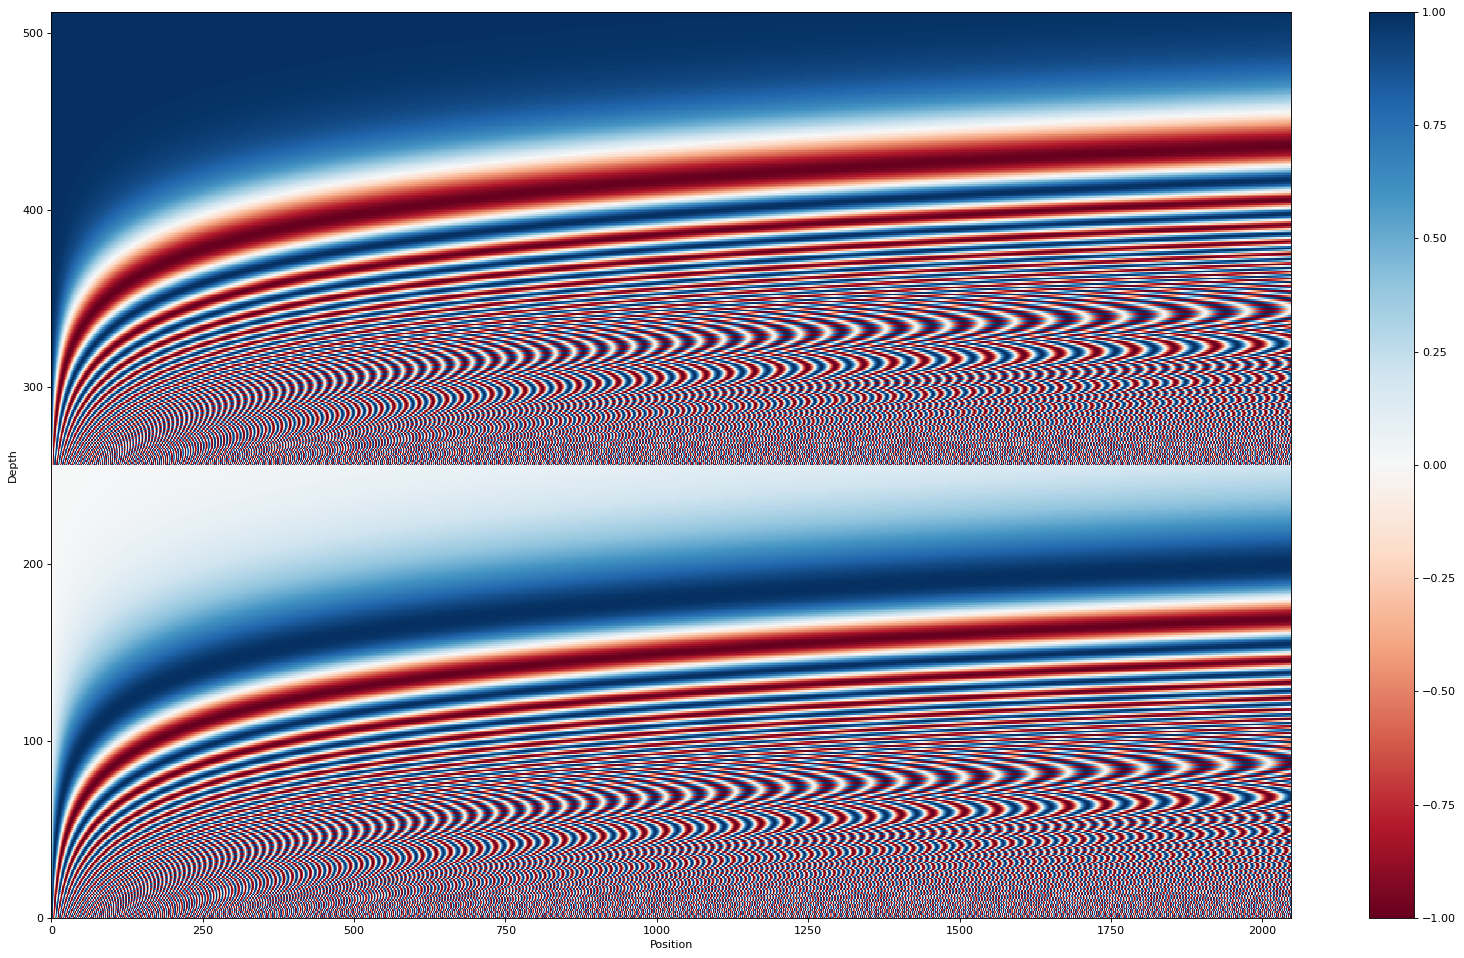

In [ ]:
# hyper paramters
pos = 2048
d_model = 512


position_encoded = PositionEncode(pos, d_model)

print('Position encode tensor: {}'.format(position_encoded.angle_rads))

# Juggle the dimensions for the plot
position_encoded = tf.reshape(position_encoded.angle_rads, (pos, d_model//2, 2))
position_encoded = tf.transpose(position_encoded, (2, 1, 0))
position_encoded = tf.reshape(position_encoded, (d_model, pos))

# specify size of chart
figure(figsize=(25, 15), dpi=80)

plt.pcolormesh(position_encoded, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Attention Mechanism


* The attention function used by the transformer takes three inputs: Q (query), K (key), V (value).

* The dot-product attention is scaled by a factor of square root of the depth. 

* For large values of depth, the dot product grows large in magnitude, pushing the softmax function where it has small gradients resulting in a very hard softmax.

### Q (query), K (key), V (value)

* As the softmax normalization is done on K, its values decide the amount of importance given to Q.

* The output represents the multiplication of the attention weights and the V (value) vector. 

* This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

In [ ]:
def attention(q, k, v, mask=None, dropout=None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  # (..., seq_len_q, seq_len_k)
  matmul_qk = tf.matmul(q, k, transpose_b=True)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1 - for probabilities.
  # (..., seq_len_q, seq_len_k)
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  

  # (..., seq_len_q, depth_v)
  output = tf.matmul(attention_weights, v)

  return output, attention_weights

* As the softmax normalization is done on K, its values decide the amount of importance given to Q.

* The output represents the multiplication of the attention weights and the V (value) vector. 

* This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

## Multi-Head Attention

Multi-head attention consists of:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer & Normalisation.

*  Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers before the multi-head attention function.

* In the diagram `(K,Q,V)` are passed through sepearte linear (`Dense`) layers for each attention head. 

* For simplicity/efficiency the code below implements this using a single dense layer with `num_heads` times as many outputs. 

* The output is rearranged to a shape of `(batch, num_heads, ...)` before applying the attention function.

* The `scaled_dot_product_attention` function defined above is applied in a single call, broadcasted for efficiency. 


* An appropriate mask must be used in the attention step.  

* The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

* Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. 

* After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

Keras API: 
* layers API: https://keras.io/api/layers/
* base layer: https://keras.io/api/layers/base_layer/
* core layers: https://keras.io/api/layers/core_layers/

Keras Dense layer without activition is linear `y(x)=x` by default and otherwise it is `y(x)=ax+b`

In [ ]:
# example of creating a dense layer: do not run this code cell
tf.keras.layers.Dense(
    units, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads
    
    # keras Dense layer without activation is linear by default
    self.wq = tf.keras.layers.Dense(d_model, activation=None)
    self.wk = tf.keras.layers.Dense(d_model, activation=None)
    self.wv = tf.keras.layers.Dense(d_model, activation=None)

    self.dense = tf.keras.layers.Dense(d_model, activation=None)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]


    # (batch_size, seq_len, d_model)
    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    # (batch_size, num_heads, seq_len_q, depth)
    q = self.split_heads(q, batch_size)  
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = attention(q, k, v, mask)

    # (batch_size, seq_len_q, num_heads, depth)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # (batch_size, seq_len_q, d_model)
    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  

    # concatenate all attention into a single output
    output = self.dense(concat_attention)

    return output, attention_weights

* Create a `MultiHeadAttention` layer to try out. 

* At each location in the sequence, `y`, the `MultiHeadAttention` runs all `8 attention heads` across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
sample_mulihead_attn = MultiHeadAttention(d_model=512, num_heads=8)

# (batch_size, encoder_sequence, d_model)
y = tf.random.uniform((1, 32, 512))  
out, attn = sample_mulihead_attn(y, k=y, q=y, mask=None)

print('Output shape: {} Attention shape: {}'.format(out.shape, attn.shape))

Output shape: (1, 32, 512) Attention shape: (1, 8, 32, 32)


In [ ]:
sample_mulihead_attn.__dict__

{'_activity_regularizer': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_compute_dtype_object': tf.float32,
 '_default_training_arg': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': True,
 '_expects_training_arg': False,
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_input_spec': None,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': True,
 '_instrumented_keras_model_class': False,
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f87aa1f2720>,
 '_name': 'multi_head_attention',
 '_non_trainable_weights': [],
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping 8>: 1, <_ObjectIdentityWrapper wrapping 512>: 1, <_ObjectIdentityWrapper wrapping 64>: 1, <_ObjectIdentityWrapper wrapping <keras.layers.core.dense.Dense object at 0x7f87aa2c03d0>>: 1, <_ObjectIdentityWrapper wrapping <

### Feed Forward Neural Network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def feed_forward_neural_net(d_model, dff=2048):
  return tf.keras.Sequential([
      # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(dff, activation='relu'),
      
      # (batch_size, seq_len, d_model)
      tf.keras.layers.Dense(d_model)
  ])

In [ ]:
sample_ffn = feed_forward_neural_net(512, 2048)
sample_ffn(tf.random.uniform((64, 256, 512))).shape

TensorShape([64, 256, 512])

# PART A [3]: Assemble Encoder and Decoder Layers (Required to construct Encoder & Decoder)

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each token in the sequence.
* The decoder attends to the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each token in the sequence.
* The decoder attends to the encoder's output and its own input (self-attention) to predict the next word. 

* The Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting. 

* Inputs not set to 0 are scaled up by `1/(1 - rate)` such that the sum over all inputs is unchanged.

* Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. 

* When using model.fit, training will be appropriately set to True automatically

* and in other contexts, you can set the `**kwarg` explicitly to True when calling the layer.

* Notes: this is in contrast to setting trainable=False for a Dropout layer. 
`trainable` does not affect the layer's behavior, as Dropout does not have any variables/weights that can be frozen during training

## Encoder Layer

### Each encoder layer consists of sublayers:

1.   Multi-head attention: must have padding mask
2.   Feed Forward Neural Networks

* Each of these sublayers has a residual connection around it followed by a layer normalization and avoids the `vanishing gradient` problem in deep networks.

*  The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. 

* There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.multihead_attn = MultiHeadAttention(d_model, num_heads)
    self.ffn = feed_forward_neural_net(d_model, dff)

    self.layernorm_01 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm_02 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout_01 = tf.keras.layers.Dropout(rate)
    self.dropout_02 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    # (batch_size, input_seq_len, d_model)
    attn_output, _ = self.multihead_attn(x, x, x, mask)  
    attn_output = self.dropout_01(attn_output, training=training)
    output_01 = self.layernorm_01(x + attn_output)

    # (batch_size, input_seq_len, d_model)
    ffn_output = self.ffn(output_01)  
    ffn_output = self.dropout_02(ffn_output, training=training)
    output_02 = self.layernorm_02(output_01 + ffn_output)

    return output_02

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 128, 512)), False, None)

# (batch_size, input_seq_len, d_model)
sample_encoder_layer_output.shape  

TensorShape([64, 128, 512])

In [ ]:
sample_encoder_layer.__dict__

{'_activity_regularizer': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_compute_dtype_object': tf.float32,
 '_default_training_arg': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': True,
 '_expects_training_arg': True,
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_input_spec': None,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': True,
 '_instrumented_keras_model_class': False,
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f87a9d72c90>,
 '_name': 'encoder_layer',
 '_non_trainable_weights': [],
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping <__main__.MultiHeadAttention object at 0x7f87a9d824d0>>: 1, <_ObjectIdentityWrapper wrapping <keras.engine.sequential.Sequential object at 0x7f87aa2c0450>>: 1, <_ObjectIdentityWrapper wrapping <keras.layers.normalization.layer_

## Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

### Layer Normalisation: `https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization`

* Normalize the activations of the previous layer for each given example in a batch independently, rather than across a batch like Batch Normalization. i.e. applies a transformation that maintains the mean activation within each example close to 0 and the activation standard deviation close to 1.

* Given a tensor inputs, moments are calculated and normalization is performed across the axes specified in axis.

In [ ]:
#  example of normalised layer - do not run code cell
tf.keras.layers.LayerNormalization(
    axis=-1, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, **kwargs
)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.multihead_attn_01 = MultiHeadAttention(d_model, num_heads)
    self.multihead_attn_02 = MultiHeadAttention(d_model, num_heads)

    self.ffn = feed_forward_neural_net(d_model, dff)

    self.layernorm_01 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm_02 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm_03 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout_01 = tf.keras.layers.Dropout(rate)
    self.dropout_02 = tf.keras.layers.Dropout(rate)
    self.dropout_03 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # (batch_size, target_seq_len, d_model)
    attn_01, attn_weights_block_01 = self.multihead_attn_01(x, x, x, look_ahead_mask) 
    attn_01 = self.dropout_01(attn_01, training=training)
    output_01 = self.layernorm_01(attn_01 + x)

    # (batch_size, target_seq_len, d_model)
    attn_02, attn_weights_block_02 = self.multihead_attn_02(enc_output, enc_output, output_01, padding_mask)  
    attn_02 = self.dropout_02(attn_02, training=training)
    
    # (batch_size, target_seq_len, d_model)
    output_02 = self.layernorm_02(attn_02 + output_01)  

    # (batch_size, target_seq_len, d_model)
    ffn_output = self.ffn(output_02)
    ffn_output = self.dropout_03(ffn_output, training=training)
    output_03 = self.layernorm_03(ffn_output + output_02)

    return output_03, attn_weights_block_01, attn_weights_block_02

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 128, 512)), sample_encoder_layer_output,False, None, None)

# (batch_size, target_seq_len, d_model)
sample_decoder_layer_output.shape  

TensorShape([64, 128, 512])

In [ ]:
sample_decoder_layer.__dict__

{'_activity_regularizer': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_compute_dtype_object': tf.float32,
 '_default_training_arg': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': False,
 '_expects_training_arg': True,
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_input_spec': None,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': True,
 '_instrumented_keras_model_class': False,
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f87a9c40750>,
 '_name': 'decoder_layer',
 '_non_trainable_weights': [],
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping <__main__.MultiHeadAttention object at 0x7f87a9c2d850>>: 1, <_ObjectIdentityWrapper wrapping <__main__.MultiHeadAttention object at 0x7f87a9b03e10>>: 1, <_ObjectIdentityWrapper wrapping <keras.engine.sequential.Sequential obje

# PART A [4]: Assemble the Ecoder and Decoder

## Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. 

The output of this summation is the input to the encoder layers. 

The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, 
               num_layers, 
               d_model, 
               num_heads, 
               dff, 
               input_vocab_size,
               maximum_position_encoding, 
               rate=0.1
               ):
    
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    
    self.position_encode = PositionEncode(maximum_position_encoding, d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    print('Encoder X:{}'.format(x))

    # adding embedding and position encoding.
    # (batch_size, input_seq_len, d_model)
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.position_encode.angle_rads[:, :seq_len, :]
    
    print('Encoder updated X: {}'.format(x))

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x

In [ ]:
sample_encoder = Encoder(num_layers=2, 
                         d_model=128, 
                         num_heads=8,
                         dff=2048, 
                         input_vocab_size=8500,
                         maximum_position_encoding=10000
                         )

dummy_input = tf.random.uniform((64, 32), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(dummy_input, training=False, mask=None)

# (batch_size, input_seq_len, d_model)
print('This is the final shape of X:{}'.format(sample_encoder_output.shape))

Encoder X:[[192  14 129 ...   4  11  87]
 [  2  54  86 ...  88  15  98]
 [162 191  28 ... 107  15 199]
 ...
 [ 53 138 122 ... 100  83 140]
 [191 138  26 ...  78  35 122]
 [108 178  61 ... 104  90   6]]
Encoder updated X: [[[-0.50565577  1.5163519   0.32701764 ...  1.2076963  -0.09620297
    1.5021352 ]
  [ 0.8259631   0.53019905  0.916775   ...  1.179871   -0.1852338
    0.9884411 ]
  [ 0.5027977   0.02756387  1.2745119  ...  0.5035323   0.16009256
    1.2832876 ]
  ...
  [-1.1777084  -0.9779389  -0.1073239  ...  0.5978353  -0.5073891
    0.84030426]
  [-0.49977717 -0.3372662   0.27123258 ...  0.48883557  0.09050454
    0.8671315 ]
  [-0.8918142   1.4580178   1.3823901  ...  0.59575343  0.22192642
    0.96601576]]

 [[-0.30541536  0.8235822   0.13117288 ...  0.6544294  -0.3864869
    1.247533  ]
  [ 0.9164399   0.29073638  1.2042744  ...  1.1278117   0.34130955
    0.7443291 ]
  [ 0.41795897 -0.26369026  0.6477058  ...  0.9085391   0.34869292
    1.2690649 ]
  ...
  [-0.82926315 -1.027

## Decoder

The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. 

The output of this positional summation is the input to the decoder layers.

The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, 
               num_layers, 
               d_model, 
               num_heads, 
               dff, 
               target_vocab_size,
               maximum_position_encoding, 
               rate=0.1
               ):
    
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.position_encode = PositionEncode(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    
    print('Decoder Sequence: {}'.format(seq_len))
    attention_weights = {}

    # (batch_size, target_seq_len, d_model)
    x = self.embedding(x)  
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.position_encode.angle_rads[:, :seq_len, :]
    print('Decoder X:{}'.format(x))

    x = self.dropout(x, training=training)

    # iterate through each layer
    for idx in range(self.num_layers):
      x, block_01, block_02 = self.dec_layers[idx](x, enc_output, training,look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{idx + 1}_block_01'] = block_01
      attention_weights[f'decoder_layer{idx + 1}_block_02'] = block_02

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, 
                         d_model=128, 
                         num_heads=8,
                         dff=2048, 
                         target_vocab_size=8000,
                         maximum_position_encoding=5000
                         )

dummy_input = tf.random.uniform((64, 32), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(dummy_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block_02'].shape

Decoder Sequence: 32
Decoder X:[[[-0.49822408  1.2838584  -0.20581003 ...  0.9211859  -0.23453543
    0.6248802 ]
  [ 0.743267    0.14370942  0.30691704 ...  1.0641147  -0.12161124
    1.3511274 ]
  [ 1.2191994   0.08340937  0.8421482  ...  0.70702714  0.5180543
    1.3911065 ]
  ...
  [-1.0900308  -0.65971196 -0.35907722 ...  1.1143607  -0.04927726
    1.1503482 ]
  [-0.69932353  0.5894542   1.2583735  ...  1.138404    0.5225993
    1.147342  ]
  [-0.58597004  0.9959401   0.7440216  ...  0.87770075  0.5445601
    0.5615922 ]]

 [[ 0.2741435   0.680156   -0.44485876 ...  0.87064195 -0.22192779
    1.1667674 ]
  [ 0.76132596  0.25757727  0.25588846 ...  0.7880279   0.0483354
    1.0292323 ]
  [ 0.35800713  0.00387168  0.7746582  ...  1.1476793   0.39837334
    0.67195976]
  ...
  [-0.7022575  -0.31222036 -0.43564248 ...  0.8878091  -0.42073706
    0.49603677]
  [-1.181649    0.12356505  0.3363227  ...  0.9935005   0.25212836
    0.93384784]
  [-0.6437096   0.6378699   1.5432749  ...  1.

(TensorShape([64, 32, 128]), TensorShape([64, 8, 32, 32]))

# PART A[5]: Create the Transformer

* Transformer:
1. encoder, 
2. decoder, and
3. final linear layer

## Data Masking

### Padding mask:
* padding mask: to ignore pad tokens in the batch of sequence and ensures that the model does not treat padding as the input. 
* The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.    

### Look-ahead mask:
* look-ahead mask: to prevent the decoder from `peaking` ahead to `cheat`.
* The look-ahead mask is used to mask (hide) the future tokens in a sequence. 
* This means that to predict the third token, only the first and second token will be used. 
* Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [ ]:
class Mask(tf.Module):
    def __init__(self, sequence, size):
        super(Mask, self).__init__()
        
        self.sequence = sequence
        self.size = size
    
    # create padding mask
    def create_padding_mask(sequence):
        sequence = tf.cast(tf.math.equal(sequence, 0), tf.float32)

        # add extra dimensions to add the padding to the attention logits
        # (batch_size, 1, 1, seq_len)
        return sequence[:, tf.newaxis, tf.newaxis, :]
    
    # create look-ahead mask
    def create_look_ahead_mask(size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        # (seq_len, seq_len)
        return mask   

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
Mask.create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
x = tf.random.uniform((1, 3))

print('Dummy X: {}'.format(x))
temp = Mask.create_look_ahead_mask(x.shape[1])
temp

Dummy X: [[0.30644524 0.6373224  0.7663901 ]]


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Create the Transformer

Components:
* encoder (which has the encoder layers and attention)
* decoder (which has the decoder layers and multihead-attention)
* masking



In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, 
               num_layers, 
               d_model, 
               num_heads, 
               dff, 
               input_vocab_size,
               target_vocab_size, 
               pe_input, 
               pe_target, 
               rate=0.1
               ):
    
    super().__init__()
    
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)


    # (batch_size, inp_seq_len, d_model)
    enc_output = self.encoder(inp, training, enc_padding_mask)  

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    # (batch_size, tar_seq_len, target_vocab_size)
    final_output = self.final_layer(dec_output)  

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = Mask.create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = Mask.create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = Mask.create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = Mask.create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

### Test the new transformer:

In [ ]:
sample_transformer = Transformer(
    num_layers=2, 
    d_model=128, 
    num_heads=8, 
    dff=2048,
    input_vocab_size=8500, 
    target_vocab_size=8000,
    pe_input=10000, 
    pe_target=6000
    )

In [ ]:
sample_transformer.__dict__

{'_activity_regularizer': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_base_model_initialized': True,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_cluster_coordinator': None,
 '_compiled_trainable_state': <WeakKeyDictionary at 0x7f87aafcc710>,
 '_compute_dtype_object': tf.float32,
 '_compute_output_and_mask_jointly': False,
 '_default_training_arg': None,
 '_distribution_strategy': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': False,
 '_expects_training_arg': True,
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_input_spec': None,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_is_compiled': False,
 '_is_graph_network': False,
 '_is_model_for_instrumentation': True,
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f87aafc2720>,
 '_name': 'transformer',
 '_non_trainable_weights': [],
 '_obj_referen

In [ ]:
dummy_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
dummy_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([dummy_input, dummy_target], training=False)

# (batch_size, tar_seq_len, target_vocab_size)
fn_out.shape  

Encoder X:[[ 68  20  83 ... 198  21 176]
 [178  81  14 ... 150 105 193]
 [ 73 161  55 ...  12  73 153]
 ...
 [190  63 122 ... 145  11 141]
 [159 184  64 ...  24 148 154]
 [ 98  40  70 ... 170  65 161]]
Encoder updated X: [[[ 4.6340668e-01  6.1800599e-01 -5.1838332e-01 ...  1.5392342e+00
   -5.3074819e-01  6.3874847e-01]
  [ 4.9418333e-01  5.8752763e-01  8.1005901e-01 ...  1.4293332e+00
    4.0992033e-01  1.2077498e+00]
  [ 1.1044677e+00 -4.0200642e-01  1.1848127e+00 ...  1.2861717e+00
   -1.6907842e-01  8.0696821e-01]
  ...
  [-8.0660164e-01 -1.0565960e+00 -1.4225450e+00 ...  7.7819091e-01
    7.4708045e-02  1.0358909e+00]
  [-7.6183873e-01  2.9223278e-02 -1.9458373e-01 ...  6.3988245e-01
   -4.6399167e-01  1.0603974e+00]
  [-1.1520672e-01  1.0059342e+00  7.6723504e-01 ...  6.2145734e-01
    3.2187325e-01  7.9667491e-01]]

 [[-2.1645868e-01  1.5635649e+00 -5.3298783e-01 ...  1.3094801e+00
   -9.1122590e-02  4.4081199e-01]
  [ 5.0208795e-01  6.2825704e-01  2.1269363e-01 ...  1.4734700e+

TensorShape([64, 36, 8000])

# PART A[5]: Model Training

## Two alternative ways to train:

1. Low-level with checkpointing
2. Customised model.fit() method

## PART A[5.1]: Low level training and checkpointing

### Hyperparameters

To keep this example small and relatively fast, the values for `num_layers, d_model, dff` have been reduced. 

The base model described in the [paper](https://arxiv.org/abs/1706.03762) used: `num_layers=6, d_model=512, dff=2048`.

In [ ]:
num_layers = 4
d_model = 128
dff = 128
num_heads = 8
dropout_rate = 0.1

### Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg_01 = tf.math.rsqrt(step)
    arg_02 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg_01, arg_02)

### Adam Optimizer: `https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam`

In [ ]:
# example for creating Adam optimizer - do not run code cell
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', **kwargs
)

### Args (Arguments)
*  `learning_rate`: A Tensor, floating point value, or a schedule that is a tf.keras.optimizers.schedules.LearningRateSchedule, or a callable that takes no arguments and returns the actual value to use, The learning rate. Defaults to 0.001.


* `beta_1`: A float value or a constant float tensor, or a callable that takes no arguments and returns the actual value to use. The exponential decay rate for the 1st moment estimates. Defaults to 0.9.


* `beta_2`: A float value or a constant float tensor, or a callable that takes no arguments and returns the actual value to use, The exponential decay rate for the 2nd moment estimates. Defaults to 0.999.


* `epsilon`: A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma and Ba paper (in the formula just before Section 2.1), not the epsilon in Algorithm 1 of the paper. Defaults to 1e-7.

* `amsgrad`: Boolean (True or  False). Whether to apply AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and beyond". Defaults to False.

*  `name`: Optional name for the operations created when applying gradients. Defaults to "Adam".

* `(**kwargs)`: Keyword arguments. Allowed to be one of "clipnorm" or "clipvalue". "clipnorm" (float) clips gradients by norm; "clipvalue" (float) clips gradients by value.


### For more information on learning rate: `https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate`

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

Text(0.5, 0, 'Training Step')

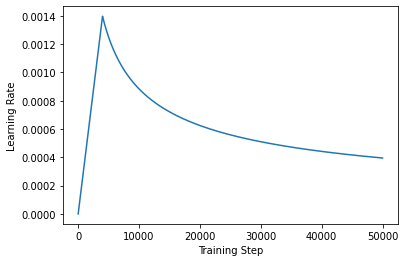

In [ ]:
learning_rate_schedule = CustomSchedule(d_model)

plt.plot(learning_rate_schedule(tf.range(50000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Training Step")

### Model training: 

* `https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit`

* `https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch`

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
loss_metric = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_metric(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [ ]:
# instantiate the transformer
pikachu = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
pikachu.compile()

In [ ]:
pikachu.__dict__

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=pikachu,optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

### Input Data

* The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. 

* `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the next token that should be predicted.

For example, `sentence` = "I love Pokemon Go"

`tar_inp` =  "I love Pokemon"

`tar_real` = "I love Pokemon Go"

* The transformer makes predictions one part at a time  (it is autorregressive), and uses its output so far to decide what to do next. 

* During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). 

* Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

* As the transformer predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

* To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [ ]:
# change this for greater accuracy but at the cost of long computation  training  time
EPOCHS = 5

## Specify the training routine

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = pikachu([inp, tar_inp],training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, pikachu.trainable_variables)
  optimizer.apply_gradients(zip(gradients, pikachu.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

### Input: Portuguese 
### Output: English (also called the `target`)

In [ ]:
# start training
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch: {epoch + 1} Batch: {batch} Loss: {train_loss.result():.4f} Accuracy: {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch: {epoch + 1} Loss: {train_loss.result():.4f} Accuracy: {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Encoder X:Tensor("inp:0", shape=(None, None), dtype=int64)
Encoder updated X: Tensor("transformer_1/encoder_2/add:0", shape=(None, None, 128), dtype=float32)
Decoder Sequence: Tensor("transformer_1/decoder_2/strided_slice:0", shape=(), dtype=int32)
Decoder X:Tensor("transformer_1/decoder_2/add:0", shape=(None, None, 128), dtype=float32)
Encoder X:Tensor("inp:0", shape=(None, None), dtype=int64)
Encoder updated X: Tensor("transformer_1/encoder_2/add:0", shape=(None, None, 128), dtype=float32)
Decoder Sequence: Tensor("transformer_1/decoder_2/strided_slice:0", shape=(), dtype=int32)
Decoder X:Tensor("transformer_1/decoder_2/add:0", shape=(None, None, 128), dtype=float32)
Epoch: 1 Batch: 0 Loss: 8.8570 Accuracy: 0.0000
Epoch: 1 Batch: 50 Loss: 8.8033 Accuracy: 0.0059
Epoch: 1 Batch: 100 Loss: 8.7039 Accuracy: 0.0250
Epoch: 1 Batch: 150 Loss: 8.5870 Accuracy: 0.0334
Epoch: 1 Batch: 200 Loss: 8.4471 Accuracy: 0.0379
Epoch: 1 Batch: 250 Loss: 8.2787 Accuracy: 0.0402
Epoch: 1 Batch: 300 Loss:

## Language Translation

The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

* Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. 

* This is redundant during inference, and only the last prediction is used.  

* This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

### Create a translator based on the Transformer

In [ ]:
# credit: Google Tensorflow Team
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    
    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)
      
      # select the last token from the seq_len dimension
      # (batch_size, 1, vocab_size)
      predictions = predictions[:, -1:, :]  

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [ ]:
pikachu_translator = Translator(tokenizers, pikachu)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

### Provide example sentences

In [ ]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

Encoder X:[[  2 125  44  85 231  84 130  84 742  16   3]]
Encoder updated X: [[[ 0.4086315   0.56127965  0.14501579 ...  0.24834031 -0.23993066
   -0.53762794]
  [ 1.9388937   0.8866875   2.3222852  ... -0.94758606  0.27924815
    0.9470178 ]
  [ 0.7457921  -0.09386888  1.1667947  ...  0.85760605  0.82927126
    0.21361226]
  ...
  [ 0.29558456  0.21506262  1.3944162  ...  1.3164248  -0.5610889
    0.8213788 ]
  [ 0.1416885  -1.8057904   2.2285051  ... -0.38727283  0.77761704
   -0.18325168]
  [-1.8018855  -0.593561    0.44910848 ...  0.23468393  0.28098834
    0.41716194]]]
Decoder Sequence: 1
Decoder X:[[[-0.49654323  0.4567042  -0.181011   -0.0066812  -0.40745237
   -0.37413383 -0.51858824 -0.14087784 -0.5146641   0.8467065
   -0.794501    0.38769674 -0.24095397  0.7000947  -0.34656897
    0.3354007  -0.42386854  0.49417943  0.13338086  0.37792546
    0.08741136  0.24724627 -0.3178673   0.3563177  -0.07781947
    0.01738149  0.21482971  0.16423255  0.38395596  0.02024668
    0.08805

In [ ]:
sentence = "Tira o cavalinho da chuva."
ground_truth = "Take your little horse out of the rain."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

Encoder X:[[   2 4498   54  436  251 3489 2025   94 1817   16    3]]
Encoder updated X: [[[ 0.4086315   0.56127965  0.14501579 ...  0.24834031 -0.23993066
   -0.53762794]
  [ 0.5984794  -0.26670015  1.0392944  ...  1.4939835  -0.28685737
    1.0531659 ]
  [ 0.7902572  -0.43754944  0.8253018  ...  0.49930745 -0.03324274
    0.29312474]
  ...
  [ 0.72661024  0.19219297 -0.26583457 ...  0.428123    1.3051075
    1.8584232 ]
  [ 0.1416885  -1.8057904   2.2285051  ... -0.38727283  0.77761704
   -0.18325168]
  [-1.8018855  -0.593561    0.44910848 ...  0.23468393  0.28098834
    0.41716194]]]
Decoder Sequence: 1
Decoder X:[[[-0.49654323  0.4567042  -0.181011   -0.0066812  -0.40745237
   -0.37413383 -0.51858824 -0.14087784 -0.5146641   0.8467065
   -0.794501    0.38769674 -0.24095397  0.7000947  -0.34656897
    0.3354007  -0.42386854  0.49417943  0.13338086  0.37792546
    0.08741136  0.24724627 -0.3178673   0.3563177  -0.07781947
    0.01738149  0.21482971  0.16423255  0.38395596  0.02024668


In [ ]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

Encoder X:[[   2  203  122  106  745  749 1404  265  469   83  265  146 1748 2527
    96   84 4802  135   16    3]]
Encoder updated X: [[[ 0.4086315   0.56127965  0.14501579 ...  0.24834031 -0.23993066
   -0.53762794]
  [ 0.28604788  0.516658   -0.15657967 ...  0.26286697  0.19305016
    1.5556788 ]
  [-0.2585854  -0.30799353  1.0757602  ...  0.37426907  0.400292
    2.6225376 ]
  ...
  [-0.312589   -0.76542413  0.7273311  ...  0.58545256 -0.29857805
    0.40414202]
  [-1.0214173  -0.23434347  1.350636   ... -0.38727498  0.7786563
   -0.18325329]
  [-1.1079872   1.2342151  -0.9217613  ...  0.2346816   0.28202763
    0.4171602 ]]]
Decoder Sequence: 1
Decoder X:[[[-0.49654323  0.4567042  -0.181011   -0.0066812  -0.40745237
   -0.37413383 -0.51858824 -0.14087784 -0.5146641   0.8467065
   -0.794501    0.38769674 -0.24095397  0.7000947  -0.34656897
    0.3354007  -0.42386854  0.49417943  0.13338086  0.37792546
    0.08741136  0.24724627 -0.3178673   0.3563177  -0.07781947
    0.01738149  0.

### Visualise the Attention learning process

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(attention_weights['decoder_layer4_block_02'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([19, 20])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'[START]', b'vou', b'entao', b'muito', b'rapidamente',
       b'partilhar', b'convosco', b'algumas', b'historias', b'de',
       b'algumas', b'coisas', b'ma', b'##gica', b'##s', b'que',
       b'acontecera', b'##m', b'.', b'[END]'], dtype=object)>

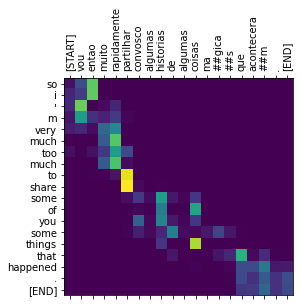

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

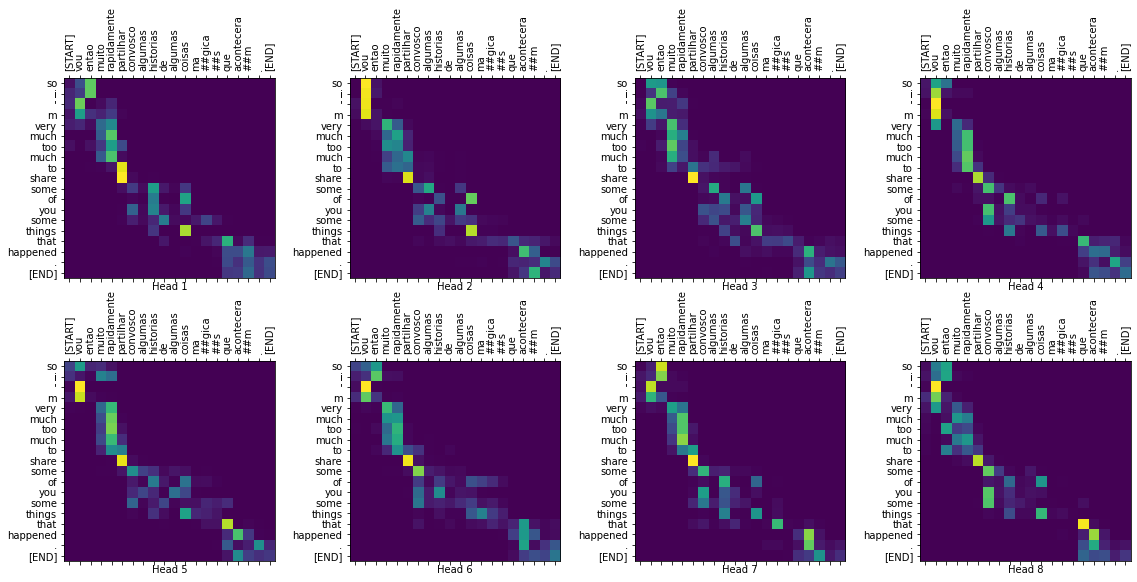

In [ ]:
plot_attention_weights(sentence, translated_tokens,attention_weights['decoder_layer4_block_02'][0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : so i ' m very much too much to share some of you some things that happened .
Ground truth   : I read about triceratops in the encyclopedia.


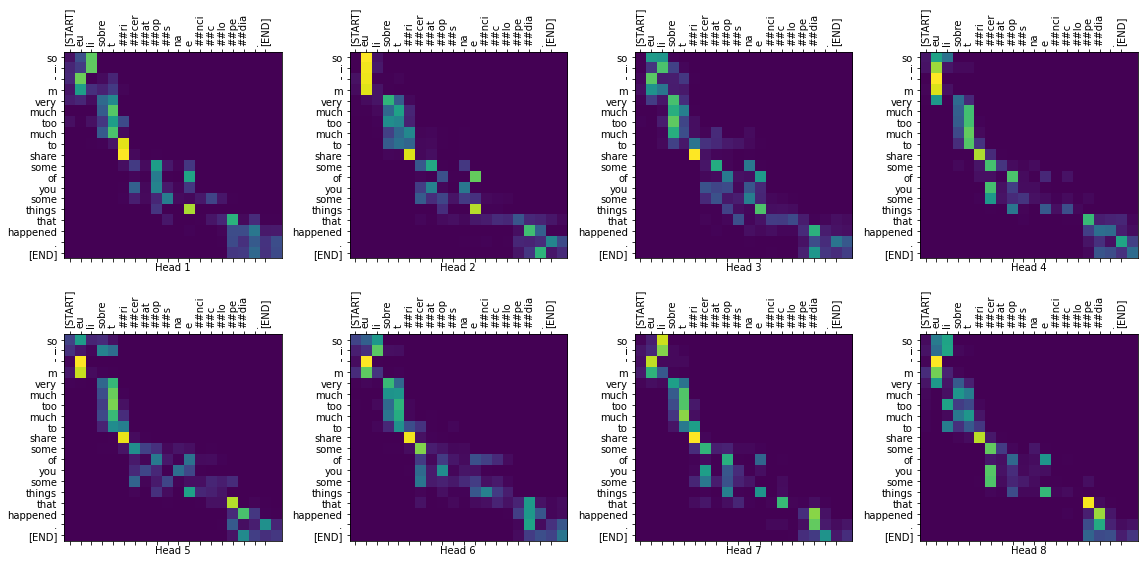

In [ ]:
# Unfamiliar words: `triceratops` or `encyclopedia` are *not* in the input dataset:

sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

#translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,attention_weights['decoder_layer4_block_02'][0])

## PART A[5.2]: Training via Model.fit()

### Construct new model:

Consists of:

* transformer architecture previously defined
* batch_data as input
* methods to calculate and track losses and accuracies 
* define the training step (could also define validation/testing steps)

In [ ]:
class PokemonTraining(tf.keras.Model):
    def __init__(self, transformer, batch_data):
        super().__init__()
    
        self.pikachu = transformer
        self.data =batch_data
        self.train_loss_tracker = tf.keras.metrics.Mean(name='train_loss')
        self.train_accuracy_tracker = tf.keras.metrics.Mean(name='train_accuracy')    
        
    def calculate_loss(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = loss_metric(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    
    
    def calculate_accuracy(self,real, pred):
        accuracies = tf.equal(real, tf.argmax(pred, axis=2))

        mask = tf.math.logical_not(tf.math.equal(real, 0))
        accuracies = tf.math.logical_and(mask, accuracies)

        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
    
    # similiar to previous training routine
    @tf.function
    def train_step(self, data):
        
        inp, tar = data
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]
        
        with tf.GradientTape() as tape:
            predictions, _ = pikachu([inp, tar_inp],training = True)
            loss = self.calculate_loss(tar_real, predictions)

            gradients = tape.gradient(loss, pikachu.trainable_variables)
            optimizer.apply_gradients(zip(gradients, pikachu.trainable_variables))
            
            accuracy =  self.calculate_accuracy(tar_real, predictions)
            
            self.train_loss_tracker.update_state(loss)
            self.train_accuracy_tracker.update_state(accuracy)
        
        return {"loss": self.train_loss_tracker.result(), "accuracy": self.train_accuracy_tracker.result()}
    
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically
        return [self.train_loss_tracker, self.train_accuracy_tracker]
    

### The same transformer architecture as before:

In [ ]:
# instantiate the transformer
pikachu = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
pikachu_transformer_training = PokemonTraining(pikachu, train_batches)

In [ ]:
pikachu_transformer_training.__dict__

{'_activity_regularizer': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_base_model_initialized': True,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_cluster_coordinator': None,
 '_compiled_trainable_state': <WeakKeyDictionary at 0x7f872cb35ed0>,
 '_compute_dtype_object': tf.float32,
 '_compute_output_and_mask_jointly': False,
 '_default_training_arg': None,
 '_distribution_strategy': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': True,
 '_expects_training_arg': True,
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_input_spec': None,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_is_compiled': False,
 '_is_graph_network': False,
 '_is_model_for_instrumentation': True,
 '_losses': [],
 '_metrics': [<keras.metrics.Mean at 0x7f872cb35950>,
 '_metrics_lock': <unlocked _thread.lock object at 0x7f872cba6840>,
 '_name': 'pokemon_training',
 '_n

### The same hyperparameters:

In [ ]:
# recall the hyperparamters
num_layers = 4
d_model = 128
dff = 128
num_heads = 8
dropout_rate = 0.1

In [ ]:
EPOCHS = 5

In [ ]:
loss_metric = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

### Introduce early stopping:
* prevents overfitting (where the AI learns well on training datasets but will perform poorly on new/unseen datasets)
* dropout was integrated into the encoder-decoder: also prevents overfitting

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### The same customised learning schedule:

In [ ]:
class CustomLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomLearningSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg_01 = tf.math.rsqrt(step)
    arg_02 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg_01, arg_02)

###  An additional parameter:

In [ ]:
num_train_steps = len(train_batches) * EPOCHS
num_train_steps

4050

### The same learning rate and optimizer:

In [ ]:
learning_rate = CustomLearningSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

### And the model could now be compiled:

In [ ]:
pikachu_transformer_training.compile(optimizer=optimizer, loss=loss_metric)

In [ ]:
pikachu_transformer_training.__dict__

{'_activity_regularizer': None,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_base_model_initialized': True,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_cluster_coordinator': None,
 '_compiled_trainable_state': <WeakKeyDictionary at 0x7f872cb62590>,
 '_compute_dtype_object': tf.float32,
 '_compute_output_and_mask_jointly': False,
 '_default_training_arg': None,
 '_distribution_strategy': None,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': True,
 '_expects_training_arg': True,
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_input_spec': None,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': False,
 '_instrumented_keras_model_class': True,
 '_is_compiled': True,
 '_is_graph_network': False,
 '_is_model_for_instrumentation': True,
 '_jit_compile': None,
 '_losses': [],
 '_metrics': [<keras.metrics.Mean at 0x7f872cb35950>,
 '_metrics_lock': <unlocked _thread.lock object at 0x7f872cba6840>,
 '_name': 'p

### The previous training method pushed data into the training step as follows:

## See: https://keras.io/api/models/model_training_apis/
Model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

In [ ]:
def batch_data(dataset):
  return (
      dataset
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

### During model.fit(), what is required is a way to push batches of data for learning:

* this is achieved by directly calling `batch_data()`:

## Finally, the new way to train our Pokemon:

In [ ]:
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
pikachu_transformer_training.fit(
    train_batches,
    steps_per_epoch=num_train_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping]
    )

In [ ]:
pikachu_transformer_training.summary()

## Language Translation

The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

* Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. 

* This is redundant during inference, and only the last prediction is used.  

* This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

In [ ]:
# credit: Google Tensorflow Team
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    
    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)
      
      # select the last token from the seq_len dimension
      # (batch_size, 1, vocab_size)
      predictions = predictions[:, -1:, :]  

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Create an instance of this `Translator` class, and try it out a few times:

In [ ]:
pikachu_translator = Translator(tokenizers, pikachu)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

In [ ]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

## Attention plots

The `Translator` class returns a dictionary of attention maps you can use to visualize the internal working of the model

In [ ]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_attention_weights(sentence, translated_tokens,attention_weights['decoder_layer4_block2'][0])

In [ ]:
# Unfamiliar words: `triceratops` or `encyclopedia` are *not* in the input dataset:

sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = pikachu_translator(tf.constant(sentence))

print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,attention_weights['decoder_layer4_block2'][0])

## End NLP Transformer
* For more examples: `https://github.com/NVIDIA`